# Exercise 7

Group Members: Luis Pazos Clemens, Robert Freund, Eugen Dizer

Deadline: 12.02.2021, 16:00.

In [1]:
#Load standard libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 4. Fitting Circles

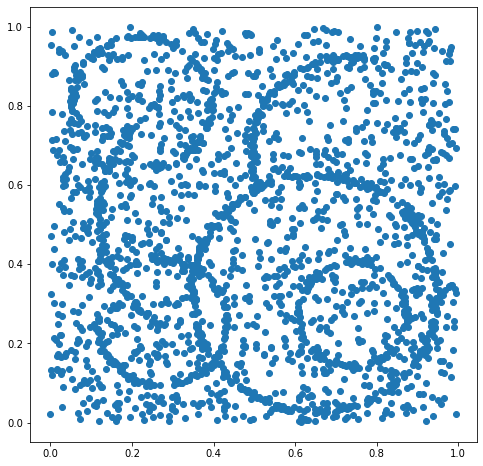

In [2]:
data = np.load("data/circles.npy")

plt.figure(figsize=(8,8))
plt.scatter(data[:,0], data[:,1])
plt.show()

The data set contains many pairs of $x$-$y$-coordinates. Some of these pairs seem to lie on circles.

As a human, we would fit six circles.

### 4.1 RANSAC

In [3]:
# Calculate a circle from three points
def cirle_from_points(points):
    # Move one point to the origin
    offset = points[0]
    p = points - offset

    # 2x2 linear eq:
    A = 2 * p[1:,:]
    b = p[1:,0]**2 + p[1:,1]**2

    try:
        center = np.dot(np.linalg.inv(A), b)
        radius = np.sqrt(center[0]**2 + center[1]**2)
    except np.linalg.linalg.LinAlgError:
        # If the points are on a straight line, there is no solution
        return np.NaN * np.zeros(2), np.NaN
    else:
        return center + offset, radius

In [4]:
# One RANSAC iteration:
def ransac_iteration(data, indices, epsilon):
    # Choose 3 points
    points = data[np.random.choice(indices, 3, replace=False)]
    # Calculate the circle through the points
    center, radius = cirle_from_points(points)
    # Check how far all other points are from the circle
    dist_from_circle = np.abs((data[:,0] - center[0])**2 + (data[:,1] - center[1])**2 - radius**2)
    # All below the epsilon theshhold are inliers
    inliers = dist_from_circle < epsilon**2

    return inliers, center, radius

# RANSAC
def ransac(data, N_circles, N_ransac, epsilon):
    # List to save all parameters of the circles
    results = []

    for i in range(N_circles):
        indices = np.arange(data.shape[0], dtype=int)       # Re-index the remaining data
        inliers_best = np.zeros(data.shape[0], dtype=bool)  # Inliers of the best solution
        score_best = 0                                      # Score of the best solution
        center_best, radius_best = np.zeros(2), 0           # Parameters of the best solution

        for i in range(N_ransac):
            # From a single sample, fit the circle and count the inliers:
            inliers, center, radius = ransac_iteration(data, indices, epsilon)
            score = np.sum(inliers)
            # Update the current best:
            if score > score_best:
                score_best, inliers_best, center_best, radius_best = score, inliers, center, radius

        results.append({'radius':radius_best, 'center':center_best, 'inliers':data[inliers_best]})
        data = data[np.logical_not(inliers_best)] # Remove all inliers before fitting the next circle
    
    return results

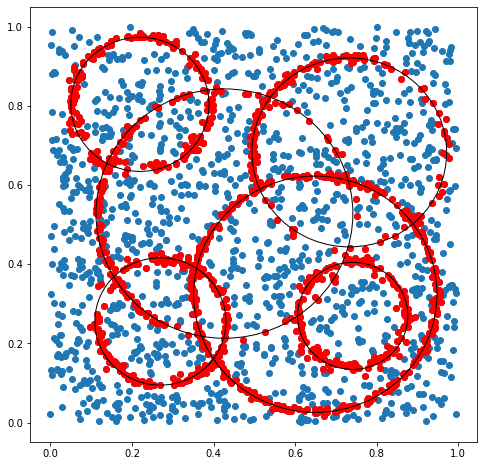

In [5]:
# Try to find six circles
fitted_circles = ransac(data, 6, 2000, 0.08)

plt.figure(figsize=(8,8))
# Plot the whole scatter plot
plt.scatter(data[:,0], data[:,1])

# Plot the fitted circles
for circ in fitted_circles:
    # Plot points on circle in different color
    plt.scatter(circ['inliers'][:,0], circ['inliers'][:,1], c='red')
    circle = plt.Circle(circ['center'], radius=circ['radius'], fill=False) # Create the circle
    plt.gca().add_patch(circle) # Add to plot

plt.show()

As we see, the algorithm worked. But the accuracy depends on $\epsilon$ and the circles are fitted using only three points of the inliers.

Therefore one can refine the fit by using all inliers.

### 4.2 Algebraic Distance

In [6]:
from scipy.optimize import least_squares

In [7]:
def refine_fit(old_fit_results):
    new_fit_results = []

    for circle in old_fit_results:
        # Cost function for least_squares
        def cost(circ):
            center, radius = circ[:2], circ[2]
            return np.sum(np.linalg.norm(circle['inliers']-center, axis=1)**2 - radius**2)

        # Use the RANSAC result as the best guess
        guess = np.concatenate((circle['center'], [circle['radius']]))
        fit = least_squares(cost, guess)
        new_fit_results.append(fit.x)

    return new_fit_results

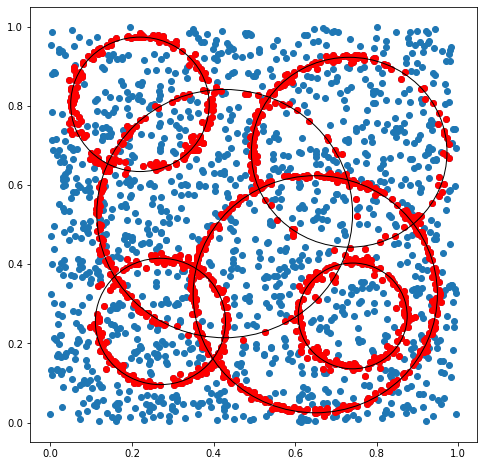

In [8]:
new_fitted_circles = refine_fit(fitted_circles)

plt.figure(figsize=(8,8))
# Plot the whole scatter plot
plt.scatter(data[:,0], data[:,1])

# Plot the inliers in a different color
for circ in fitted_circles:
    plt.scatter(circ['inliers'][:,0], circ['inliers'][:,1], c='red')

# Plot the new fitted circles
for circ in new_fitted_circles:
    circle = plt.Circle(circ[:2], radius=circ[2], fill=False) # Create the circle
    plt.gca().add_patch(circle) # Add to plot

plt.show()

We see that the circles are only refined slightly.

### 4.3 Levenberg-Marquardt

The only thing that really changes compared to the algebraic distance approach is the cost function.

In [9]:
def refine_fit(old_fit_results):
    new_fit_results = []

    for circle in old_fit_results:
        # Cost function for least_squares
        def cost(circ):
            center, radius = circ[:2], circ[2]
            return np.sum(np.linalg.norm(circle['inliers']-center, axis=1) - radius)

        # Use the RANSAC result as the best guess
        guess = np.concatenate((circle['center'], [circle['radius']]))
        fit = least_squares(cost, guess)
        new_fit_results.append(fit.x)

    return new_fit_results

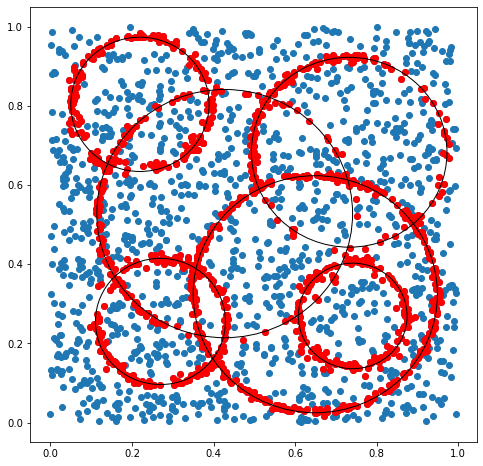

In [10]:
new_fitted_circles = refine_fit(fitted_circles)

plt.figure(figsize=(8,8))
# Plot the whole scatter plot
plt.scatter(data[:,0], data[:,1])

# Plot the inliers in a different color
for circ in fitted_circles:
    plt.scatter(circ['inliers'][:,0], circ['inliers'][:,1], c='red')

# Plot the new fitted circles
for circ in new_fitted_circles:
    circle = plt.Circle(circ[:2], radius=circ[2], fill=False) # Create the circle
    plt.gca().add_patch(circle) # Add to plot

plt.show()